In [1]:
!pip install numpy
!pip install gym

import numpy as np #for our Qtable
import gym #for our cartpole Environment
import random #to generate random numbers
import pandas

#neural network packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.python.keras import utils

#code for rendering gui
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install pyglet==1.4.0
!apt-get install x11-utils

import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (665 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 784 kB of 

In [2]:
#discreization parameters
n_bins = 8
n_bins_angle = 10
# Number of states is huge so in order to simplify the situation
# we discretize the space to: 10 ** number_of_features
cart_position_bins = pandas.cut([-2.4, 2.4], bins=n_bins, retbins=True)[1][1:-1]
pole_angle_bins = pandas.cut([-2, 2], bins=n_bins_angle, retbins=True)[1][1:-1]
cart_velocity_bins = pandas.cut([-1, 1], bins=n_bins, retbins=True)[1][1:-1]
angle_rate_bins = pandas.cut([-3.5, 3.5], bins=n_bins_angle, retbins=True)[1][1:-1]

In [3]:
def to_bin(value, bins):
    return np.digitize(x=[value], bins=bins)[0]

In [4]:
def build_state(features):
    return int("".join(map(lambda feature: str(int(feature)), features)))

In [5]:
class DQN():
  def __init__(self,state_space,action_space):
    self.learning_rate = 0.2          # Learning rate
    self.gamma = 0.95                 # Discounting rate

    # Exploration parameters
    self.epsilon = 0.99                 # Exploration rate
    self.max_epsilon = 0.99             # Exploration probability at start
    self.min_epsilon = 0.1            # Minimum exploration probability 
    self.decay_rate = 0.995            # Exponential decay rate for exploration prob

    #neural network parameters
    self.state_space = state_space
    self.action_space=action_space
    self.batch_size =1
    self.input_size = 1
    self.output_size = action_space.n
    self.model = self.buildQNetwork()
  
  def buildQNetwork(self):
    model = Sequential()
    model.add(Dense(10, input_dim=self.input_size, activation='relu'))#fully connected
    model.add(Dense(10, activation='relu'))
    model.add(Dense(self.output_size))
    model.compile(loss='mse', optimizer='adam')
    return model
    
  def chooseAction(self,state,isEpsilonGreedy):
    exp_exp_tradeoff = random.uniform(0, 1)
    
    if exp_exp_tradeoff > self.epsilon or not isEpsilonGreedy:
        qval = self.model.predict(np.reshape(state,(1, self.input_size)))
        maxqval = max(qval)
        action= np.where(qval == maxqval)[0][0]
        print("Qaction",action)
       
    else:
        action = self.action_space.sample()
        print("random action",action)
    return action

  def updateEpsilon(self,episode):
    self.epsilon *= self.decay_rate
    if(self.epsilon < self.min_epsilon):
      self.epsilon = self.min_epsilon
    #print(self.epsilon)
    #self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon)*np.exp(-self.decay_rate*episode) 

  def calcualteTargetValue(self,state, action, reward, next_state, isDone):
    
    #old_qvalue = self.model.predict(np.reshape(state,(1, self.input_size)))
    qnext = self.model.predict(np.reshape(next_state,(1, self.input_size)))
    maxqval = max(qnext)
   
    if isDone:
      target_value = reward
    else:
      target_value = reward + self.gamma *maxqval 

    return target_value

  def train(self,state,action,reward,next_state,isDone):
    X_train = np.zeros((self.batch_size, self.input_size))
    Y_train = np.zeros((self.batch_size, self.output_size))
    X_train[0] = state
    Y_train[0] = self.calcualteTargetValue(state,action,reward,next_state,isDone)
    loss = self.model.train_on_batch(X_train, Y_train)
    print(loss)
    return loss

[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0] 10.0
Score over time: 9.95


array([ 0.04772214, -0.03802545,  0.02237955,  0.01685398])

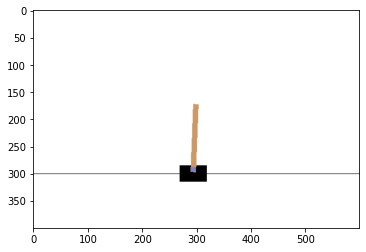

In [9]:
env = gym.make("CartPole-v1")

rewards = []

learner = DQN(env.observation_space,env.action_space)
total_episodes = 20      # Total episodes
max_steps = 10               # Max steps per episode
for episode in range(total_episodes): 
    # Reset the environment
    cart_position, pole_angle, cart_velocity, angle_rate_of_change = env.reset()
  
    state = build_state([to_bin(cart_position, cart_position_bins),
                        to_bin(pole_angle, pole_angle_bins),
                        to_bin(cart_velocity, cart_velocity_bins),
                        to_bin(angle_rate_of_change, angle_rate_bins)])
    step = 0
    done = False
    total_rewards = 0
    loss =0
    prev_screen = env.render(mode='rgb_array')
    plt.imshow(prev_screen)
    for step in range(max_steps): 
      screen = env.render(mode='rgb_array')
      plt.imshow(screen)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())
    
      
      action = learner.chooseAction(state,True)
      # Take the action (a) and observe the outcome state(s') and reward (r)
      observation, reward, done, info = env.step(action)

      cart_position, pole_angle, cart_velocity, angle_rate_of_change = observation
      new_state = build_state([to_bin(cart_position, cart_position_bins),
                        to_bin(pole_angle, pole_angle_bins),
                        to_bin(cart_velocity, cart_velocity_bins),
                        to_bin(angle_rate_of_change, angle_rate_bins)])


      #Calcualte the loss and train (optimize) the Q-network
      learner.train(state,action,reward, new_state,done)
      
      total_rewards += reward
      
      # Our new state is state
      state = new_state
      
      # If done (if we're dead) : finish episode
      if done == True: 
          break
  # Reduce epsilon (because we need less and less exploration)
      learner.updateEpsilon(episode)
    rewards.append(total_rewards)
    ipythondisplay.clear_output(wait=True)
print(rewards, max(rewards))
print ("Score over time: " +  str(sum(rewards)/total_episodes))
env.reset()

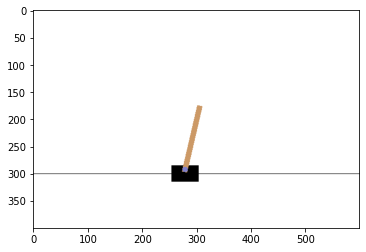

In [8]:
for episode in range(5):
    cart_position, pole_angle, cart_velocity, angle_rate_of_change = env.reset()
   
    state = build_state([to_bin(cart_position, cart_position_bins),
                         to_bin(pole_angle, pole_angle_bins),
                         to_bin(cart_velocity, cart_velocity_bins),
                         to_bin(angle_rate_of_change, angle_rate_bins)])
    step = 0
    done = False
    print("****************************************************")
    print("EPISODE ", episode)
    prev_screen = env.render(mode='rgb_array')
    plt.imshow(prev_screen)
    for step in range(max_steps):
        
        # Take the action (index) that have the maximum expected future reward given that state
        action = learner.chooseAction(state,False)
        
        observation, reward, done, info = env.step(action)
        cart_position, pole_angle, cart_velocity, angle_rate_of_change = observation
        new_state = build_state([to_bin(cart_position, cart_position_bins),
                          to_bin(pole_angle, pole_angle_bins),
                          to_bin(cart_velocity, cart_velocity_bins),
                          to_bin(angle_rate_of_change, angle_rate_bins)])
        screen = env.render(mode='rgb_array')
        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
        if done:
          break
        state = new_state
    ipythondisplay.clear_output(wait=True)
env.close()